**GOAL**

- Understand the clients number evolution through time.
- Evaluate the clustering stability through time.

**Table of contents**<a id='toc0_'></a>    
- 1. [Load orders summaries](#toc1_)    
- 2. [Test : compute clients evolution through time on a small part of the dataset](#toc2_)    
- 3. [Create clients summaries df at different dates](#toc3_)    
- 4. [Results : clients' summaries at different dates.](#toc4_)    
  - 4.1. [Create variables and organize them in a dictionary](#toc4_1_)    
  - 4.2. [Inspect nulls and extreme values](#toc4_2_)    
- 5. [Clients number evolution through time](#toc5_)    
- 6. [Pre-processing data for clustering](#toc6_)    
- 7. [Fit different Kmeans on each clients summaries (date-wise) to predict labels having all information.](#toc7_)    
- 8. [For each clients summaries at a certain date, add all predictions of labels with previous kmeans.](#toc8_)    
- 9. [Adjusted rand index between the different kmeans models predictions.](#toc9_)    
- 10. [Centroids trajectories (stability)](#toc10_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import project_tools_v2 as pt
import data_science_functions as ds

from glob import glob
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.decomposition import PCA
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

pd.set_option('display.max_columns', 75)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', None)


# 1.  [&#9650;](#toc0_) <a id='toc1_'></a>Load orders summaries

In [5]:
# Load orders summaries
orders_df = pd.read_csv('orders_summary.csv.gz')
orders_df.loc[:, 'purchase_time'] = pd.to_datetime(orders_df.loc[:, 'purchase_time'])
orders_df.loc[:, 'delivery_time'] = pd.to_datetime(orders_df.loc[:, 'delivery_time'])
display(orders_df.head())
orders_df.info()

,customer_unique_id,order_id,order_status,binary_order_status,purchase_time,delivery_time,n_items,order_cost,order_cost_minus_payment,review_score,payment_installments,days_between_purchase_and_delivery,hour_of_purchase,weekday_of_purchase,value_home,value_sports_leisure,value_electronics_and_multimedia,value_unknown,value_toys,value_auto,value_tools_and_professional_material,value_health_and_beauty,value_pet_shop,value_baby,value_watches_gifts,value_art_cinema_music,value_stationery,value_fashion,value_other,value_books,value_security,freight,freight_value,payment_value_credit_card,payment_value_debit_card,payment_value_voucher,payment_value_boleto,payment_value_not_defined
0,0000366f3b9a7992bf8c76cfdf3221e2,e22acc9c116caa3f2b7121bbb380d08e,delivered,delivered,2018-05-10 10:56:27,2018-05-16 20:48:37,1.0,141.90,0.0,5.0,8.0,6.0,10.0,3.0,129.9,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.00,141.90,0.0,0.0,0.0,0.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,3594e05a005ac4d06a72673270ef9ec9,delivered,delivered,2018-05-07 11:11:27,2018-05-10 18:02:42,1.0,27.19,0.0,4.0,1.0,3.0,11.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,18.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.29,27.19,0.0,0.0,0.0,0.0
2,0000f46a3911fa3c0805444483337064,b33ec3b699337181488304f362a6b734,delivered,delivered,2017-03-10 21:05:03,2017-04-05 14:38:47,1.0,86.22,0.0,3.0,8.0,25.0,21.0,4.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69.0,0.0,0.0,0.0,0.0,0.0,17.22,86.22,0.0,0.0,0.0,0.0
3,0000f6ccb0745a6a4b88665a16c9f078,41272756ecddd9a9ed0180413cc22fb6,delivered,delivered,2017-10-12 20:29:41,2017-11-01 21:23:05,1.0,43.62,0.0,4.0,4.0,20.0,20.0,3.0,0.0,0.0,25.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.63,43.62,0.0,0.0,0.0,0.0
4,0004aac84e0df4da2b147fca70cf8255,d957021f1127559cd947b62533f484f7,delivered,delivered,2017-11-14 19:45:42,2017-11-27 23:08:56,1.0,196.89,0.0,5.0,6.0,13.0,19.0,1.0,0.0,0.0,180.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.89,196.89,0.0,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 38 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   customer_unique_id                     99441 non-null  object 
 1   order_id                               99441 non-null  object 
 2   order_status                           99441 non-null  object 
 3   binary_order_status                    99441 non-null  object 
 4   purchase_time                          99441 non-null  object 
 5   delivery_time                          96476 non-null  object 
 6   n_items                                98666 non-null  float64
 7   order_cost                             99441 non-null  float64
 8   order_cost_minus_payment               99441 non-null  float64
 9   review_score                           99441 non-null  float64
 10  payment_installments                   99441 non-null  float64
 11  da

In [22]:
orders_df.purchase_time.max()

Timestamp('2018-10-17 17:30:18')

# 2.  [&#9650;](#toc0_) <a id='toc2_'></a>Test : compute clients evolution through time on a small part of the dataset

In [20]:
t0 = pd.Timestamp('2017-01-01 00:00:00')
clients_t0 = pt.make_clients_summary_relative_to_a_date_for_clustering(orders_df, t0)

Purchase_time dtype : datetime64[ns]
orders_df shape at that date : (329, 45)


In [23]:
clients_t0.head(15)

,monetary_value_sum,days_delivery_mean,total_number_of_purchases,value_ratio_p2_p1,days_last_purchase,review_score_mean,ratio_value_home,ratio_value_electronics_and_multimedia,ratio_value_health_and_beauty,new_ratio_value_other,ratio_freight_value,ratio_payment_value_credit_card,ratio_payment_value_boleto
customer_unique_id,,,,,,,,,,,,,
0032c76b20340da25249092a268ce66c,144.94,26.0,1,1.0,86.0,4.0,0.000000,0.000000,0.000000,0.889334,0.110666,1.0,0.0
01f156677184504063bd19739f924af1,784.80,7.0,1,1.0,82.0,5.0,0.942890,0.000000,0.000000,0.000000,0.057110,1.0,0.0
0636d30c77f0f9cfad81f1c9b58c791f,971.96,9.0,1,1.0,84.0,4.0,0.000000,0.977396,0.000000,0.000000,0.022604,1.0,0.0
06bdfbbe1857c3c925ec81abfb1c9666,196.27,15.0,1,1.0,88.0,5.0,0.000000,0.000000,0.000000,0.916594,0.083406,1.0,0.0
0829f7df6577d5a4b65439bea701405f,267.49,12.0,1,1.0,88.0,3.0,0.000000,0.000000,0.934241,0.000000,0.065759,1.0,0.0
08da95f931937b2c20f5225f2e6c93b0,80.94,15.0,1,1.0,82.0,5.0,0.000000,0.000000,0.000000,0.852483,0.147517,1.0,0.0
0922f37485310929b1b94e8f0c984ca5,156.22,7.0,1,1.0,86.0,5.0,0.000000,0.000000,0.000000,0.896108,0.103892,1.0,0.0
0a02ba4243b1b0e048a3841d5758d113,143.40,7.0,1,1.0,84.0,1.0,0.683403,0.000000,0.000000,0.000000,0.316597,1.0,0.0
0ac6c084c9623a0e2ace60297ad24d6c,212.32,13.0,1,1.0,85.0,5.0,0.912773,0.000000,0.000000,0.000000,0.087227,1.0,0.0


In [31]:
# Prepare dates of examinations
t0 = pd.Timestamp('2017-01-01 00:00:00')
dates = pd.date_range(t0, periods=2, freq='10D')
dates

DatetimeIndex(['2017-01-01', '2017-01-11'], dtype='datetime64[ns]', freq='10D')

In [34]:
for k, date in enumerate(dates):
    print(date)
    df = pt.make_clients_summary_relative_to_a_date_for_clustering(orders_df, date)
    exec( 'clients_t' + str(k) + ' = df')

2017-01-01 00:00:00
Purchase_time dtype : datetime64[ns]
orders_df shape at that date : (329, 45)
2017-01-11 00:00:00
Purchase_time dtype : datetime64[ns]
orders_df shape at that date : (380, 45)


In [39]:
print(clients_t0.shape)
clients_t0.head()

(269, 13)


,monetary_value_sum,days_delivery_mean,total_number_of_purchases,value_ratio_p2_p1,days_last_purchase,review_score_mean,ratio_value_home,ratio_value_electronics_and_multimedia,ratio_value_health_and_beauty,new_ratio_value_other,ratio_freight_value,ratio_payment_value_credit_card,ratio_payment_value_boleto
customer_unique_id,,,,,,,,,,,,,
0032c76b20340da25249092a268ce66c,144.94,26.0,1,1.0,86.0,4.0,0.00000,0.000000,0.000000,0.889334,0.110666,1.0,0.0
01f156677184504063bd19739f924af1,784.80,7.0,1,1.0,82.0,5.0,0.94289,0.000000,0.000000,0.000000,0.057110,1.0,0.0
0636d30c77f0f9cfad81f1c9b58c791f,971.96,9.0,1,1.0,84.0,4.0,0.00000,0.977396,0.000000,0.000000,0.022604,1.0,0.0
06bdfbbe1857c3c925ec81abfb1c9666,196.27,15.0,1,1.0,88.0,5.0,0.00000,0.000000,0.000000,0.916594,0.083406,1.0,0.0
0829f7df6577d5a4b65439bea701405f,267.49,12.0,1,1.0,88.0,3.0,0.00000,0.000000,0.934241,0.000000,0.065759,1.0,0.0


In [41]:
print(clients_t1.shape)
clients_t1.head()

(303, 13)


,monetary_value_sum,days_delivery_mean,total_number_of_purchases,value_ratio_p2_p1,days_last_purchase,review_score_mean,ratio_value_home,ratio_value_electronics_and_multimedia,ratio_value_health_and_beauty,new_ratio_value_other,ratio_freight_value,ratio_payment_value_credit_card,ratio_payment_value_boleto
customer_unique_id,,,,,,,,,,,,,
0032c76b20340da25249092a268ce66c,144.94,26.0,1,0.0,96.0,4.0,0.00000,0.000000,0.000000,0.889334,0.110666,1.0,0.0
01f156677184504063bd19739f924af1,784.80,7.0,1,0.0,92.0,5.0,0.94289,0.000000,0.000000,0.000000,0.057110,1.0,0.0
0636d30c77f0f9cfad81f1c9b58c791f,971.96,9.0,1,0.0,94.0,4.0,0.00000,0.977396,0.000000,0.000000,0.022604,1.0,0.0
06bdfbbe1857c3c925ec81abfb1c9666,196.27,15.0,1,0.0,98.0,5.0,0.00000,0.000000,0.000000,0.916594,0.083406,1.0,0.0
0829f7df6577d5a4b65439bea701405f,267.49,12.0,1,0.0,98.0,3.0,0.00000,0.000000,0.934241,0.000000,0.065759,1.0,0.0


# 3.  [&#9650;](#toc0_) <a id='toc3_'></a>Create clients summaries df at different dates

For computational reasons, I am going to make this study in the early stage of the platform because computing clients summaries for a given date takes more time the more the data. Right above are the dates :

In [13]:
# Prepare dates of examinations
t0 = pd.Timestamp('2017-06-01 00:00:00')
dates = pd.date_range(t0, periods=10, freq='10D')
dates

DatetimeIndex(['2017-06-01', '2017-06-11', '2017-06-21', '2017-07-01',
               '2017-07-11', '2017-07-21', '2017-07-31', '2017-08-10',
               '2017-08-20', '2017-08-30'],
              dtype='datetime64[ns]', freq='10D')

In [43]:
for k, date in enumerate(dates):
    print(date)
    df = pt.make_clients_summary_relative_to_a_date_for_clustering(orders_df, date)
    df_name = 'clients_t' + str(k)
    print(df_name)
    exec(df_name + ' = df')
    df.to_csv(df_name + '.csv.gz')

2017-06-01 00:00:00
Purchase_time dtype : datetime64[ns]
orders_df shape at that date : (11566, 45)
clients_t0
2017-06-11 00:00:00
Purchase_time dtype : datetime64[ns]
orders_df shape at that date : (12792, 45)
clients_t1
2017-06-21 00:00:00
Purchase_time dtype : datetime64[ns]
orders_df shape at that date : (13893, 45)
clients_t2
2017-07-01 00:00:00
Purchase_time dtype : datetime64[ns]
orders_df shape at that date : (14845, 45)
clients_t3
2017-07-11 00:00:00
Purchase_time dtype : datetime64[ns]
orders_df shape at that date : (15969, 45)
clients_t4
2017-07-21 00:00:00
Purchase_time dtype : datetime64[ns]
orders_df shape at that date : (17441, 45)
clients_t5
2017-07-31 00:00:00
Purchase_time dtype : datetime64[ns]
orders_df shape at that date : (18701, 45)
clients_t6
2017-08-10 00:00:00
Purchase_time dtype : datetime64[ns]
orders_df shape at that date : (20105, 45)
clients_t7
2017-08-20 00:00:00
Purchase_time dtype : datetime64[ns]
orders_df shape at that date : (21573, 45)
clients_t8
2

In [45]:
!ls -Fsh

total 106M
7,0M clients_2_cleaned.csv.gz
7,0M clients_2.csv.gz
2,8M clients.csv.gz
2,9M clients_rfm.csv.gz
4,6M clients_second_fts_engineering.csv.gz
500K clients_t0.csv.gz
556K clients_t1.csv.gz
604K clients_t2.csv.gz
644K clients_t3.csv.gz
700K clients_t4.csv.gz
760K clients_t5.csv.gz
812K clients_t6.csv.gz
876K clients_t7.csv.gz
940K clients_t8.csv.gz
996K clients_t9.csv.gz
2,9M clients_with_kmeans_and_hc_labels.csv.gz
 26M clustering_models.ipynb
 13M clustering_models_part2.ipynb
 24K CR-semaine-24-avril.odt
 24K CR-semaine-24-avril.pdf
4,0K csv_files/
 80K data_schema.png
 28K data_science_functions.py
4,0K ideas.md
4,0K maintenance_simulations.ipynb
 19M merged_df.csv.gz
8,2M Olist_EDA_and_feature_engineering.ipynb
7,2M orders_summary.csv.gz
 24K project_tools.py
 28K project_tools_v2.py
4,0K __pycache__/
4,0K questions.md
4,0K README.md


# 4.  [&#9650;](#toc0_) <a id='toc4_'></a>Results : clients' summaries at different dates.

## 4.1.  [&#9650;](#toc0_) <a id='toc4_1_'></a>Create variables and organize them in a dictionary

In [11]:
# Catch and load all clients summaries make though the 10 dates
# in a variable called clients-tn where n in [[0, 9]]
filenames = glob('clients_t*')

for filename in filenames:
    df = pd.read_csv(filename, index_col="customer_unique_id")
    var = filename.rstrip('.csvgz')
    exec(var + ' = df')

In [49]:
# Dictionary of those clients summaries ; key 'tn'
clients_summary = {'t'+ str(k): eval('clients_t' +str(k)) for k in range(10)}

## 4.2.  [&#9650;](#toc0_) <a id='toc4_2_'></a>Inspect nulls and extreme values

In [50]:
# Checking there is no null values and that values are within a relevant range
for time, clients in clients_summary.items():
    print(f'clients at {time}')
    display(clients.isnull().mean() * 100)
    display(clients.describe())

clients at t0


monetary_value_sum                        0.0
days_delivery_mean                        0.0
total_number_of_purchases                 0.0
value_ratio_p2_p1                         0.0
days_last_purchase                        0.0
review_score_mean                         0.0
ratio_value_home                          0.0
ratio_value_electronics_and_multimedia    0.0
ratio_value_health_and_beauty             0.0
new_ratio_value_other                     0.0
ratio_freight_value                       0.0
ratio_payment_value_credit_card           0.0
ratio_payment_value_boleto                0.0
dtype: float64

,monetary_value_sum,days_delivery_mean,total_number_of_purchases,value_ratio_p2_p1,days_last_purchase,review_score_mean,ratio_value_home,ratio_value_electronics_and_multimedia,ratio_value_health_and_beauty,new_ratio_value_other,ratio_freight_value,ratio_payment_value_credit_card,ratio_payment_value_boleto
count,10707.000000,10707.000000,10707.000000,10707.000000,10707.000000,10707.000000,10707.000000,10707.000000,10707.000000,10707.000000,10707.000000,10707.000000,10707.000000
mean,167.880092,12.484885,1.024657,0.748747,62.468572,4.185844,0.219225,0.112558,0.096582,0.359721,0.211914,0.740162,0.215537
std,261.516380,11.289319,0.173289,0.435941,47.031271,1.227317,0.354292,0.272255,0.267291,0.407500,0.130598,0.433579,0.410891
min,12.280000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.004235,0.000000,0.000000
25%,60.555000,7.000000,1.000000,0.000000,24.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.116796,0.128681,0.000000
50%,105.380000,10.000000,1.000000,1.000000,57.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.183010,1.000000,0.000000
75%,182.925000,15.000000,1.000000,1.000000,91.000000,5.000000,0.622500,0.000000,0.000000,0.812742,0.280790,1.000000,0.000000
max,7571.630000,209.000000,6.000000,4.870000,258.000000,5.000000,0.971958,0.993473,0.982821,0.995765,0.851621,1.000000,1.000000


clients at t1


monetary_value_sum                        0.0
days_delivery_mean                        0.0
total_number_of_purchases                 0.0
value_ratio_p2_p1                         0.0
days_last_purchase                        0.0
review_score_mean                         0.0
ratio_value_home                          0.0
ratio_value_electronics_and_multimedia    0.0
ratio_value_health_and_beauty             0.0
new_ratio_value_other                     0.0
ratio_freight_value                       0.0
ratio_payment_value_credit_card           0.0
ratio_payment_value_boleto                0.0
dtype: float64

,monetary_value_sum,days_delivery_mean,total_number_of_purchases,value_ratio_p2_p1,days_last_purchase,review_score_mean,ratio_value_home,ratio_value_electronics_and_multimedia,ratio_value_health_and_beauty,new_ratio_value_other,ratio_freight_value,ratio_payment_value_credit_card,ratio_payment_value_boleto
count,11852.000000,11852.000000,11852.000000,11852.000000,11852.000000,11852.000000,11852.000000,11852.000000,11852.000000,11852.000000,11852.000000,11852.000000,11852.000000
mean,167.707249,12.395067,1.025565,0.711150,65.900354,4.190319,0.217483,0.112588,0.098232,0.360202,0.211495,0.740051,0.215216
std,259.353325,11.027840,0.175558,0.455734,48.928908,1.223922,0.353250,0.272455,0.269383,0.407431,0.129856,0.433499,0.410647
min,12.280000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.004235,0.000000,0.000000
25%,60.672500,7.000000,1.000000,0.000000,26.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.116843,0.131510,0.000000
50%,105.590000,10.000000,1.000000,1.000000,59.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.183256,1.000000,0.000000
75%,181.650000,15.000000,1.000000,1.000000,96.000000,5.000000,0.616217,0.000000,0.000000,0.812717,0.280232,1.000000,0.000000
max,7571.630000,209.000000,6.000000,4.870000,268.000000,5.000000,0.971958,0.993473,0.984886,0.995765,0.851621,1.000000,1.000000


clients at t2


monetary_value_sum                        0.0
days_delivery_mean                        0.0
total_number_of_purchases                 0.0
value_ratio_p2_p1                         0.0
days_last_purchase                        0.0
review_score_mean                         0.0
ratio_value_home                          0.0
ratio_value_electronics_and_multimedia    0.0
ratio_value_health_and_beauty             0.0
new_ratio_value_other                     0.0
ratio_freight_value                       0.0
ratio_payment_value_credit_card           0.0
ratio_payment_value_boleto                0.0
dtype: float64

,monetary_value_sum,days_delivery_mean,total_number_of_purchases,value_ratio_p2_p1,days_last_purchase,review_score_mean,ratio_value_home,ratio_value_electronics_and_multimedia,ratio_value_health_and_beauty,new_ratio_value_other,ratio_freight_value,ratio_payment_value_credit_card,ratio_payment_value_boleto
count,12875.000000,12875.000000,12875.000000,12875.000000,12875.000000,12875.000000,12875.000000,12875.000000,12875.000000,12875.000000,12875.000000,12875.000000,12875.000000
mean,167.287719,12.361838,1.026641,0.668297,70.233476,4.191049,0.216313,0.113477,0.097595,0.361164,0.211452,0.740069,0.215014
std,257.490360,10.932196,0.178428,0.473152,50.709208,1.223113,0.352692,0.273124,0.268786,0.407510,0.129573,0.433596,0.410509
min,12.280000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.004235,0.000000,0.000000
25%,60.850000,7.000000,1.000000,0.000000,30.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.117062,0.130622,0.000000
50%,105.370000,10.000000,1.000000,1.000000,61.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.183411,1.000000,0.000000
75%,180.630000,15.000000,1.000000,1.000000,103.000000,5.000000,0.611734,0.000000,0.000000,0.812706,0.280563,1.000000,0.000000
max,7571.630000,209.000000,6.000000,4.870000,278.000000,5.000000,0.971958,0.993473,0.984886,0.995765,0.851621,1.000000,1.000000


clients at t3


monetary_value_sum                        0.0
days_delivery_mean                        0.0
total_number_of_purchases                 0.0
value_ratio_p2_p1                         0.0
days_last_purchase                        0.0
review_score_mean                         0.0
ratio_value_home                          0.0
ratio_value_electronics_and_multimedia    0.0
ratio_value_health_and_beauty             0.0
new_ratio_value_other                     0.0
ratio_freight_value                       0.0
ratio_payment_value_credit_card           0.0
ratio_payment_value_boleto                0.0
dtype: float64

,monetary_value_sum,days_delivery_mean,total_number_of_purchases,value_ratio_p2_p1,days_last_purchase,review_score_mean,ratio_value_home,ratio_value_electronics_and_multimedia,ratio_value_health_and_beauty,new_ratio_value_other,ratio_freight_value,ratio_payment_value_credit_card,ratio_payment_value_boleto
count,13768.000000,13768.000000,13768.000000,13768.000000,13768.000000,13768.000000,13768.000000,13768.000000,13768.000000,13768.000000,13768.000000,13768.000000,13768.000000
mean,166.700105,12.257481,1.026947,0.632111,75.308324,4.193413,0.220031,0.111749,0.097143,0.359284,0.211793,0.739546,0.216172
std,255.403041,10.737232,0.179384,0.496089,52.456114,1.221335,0.354521,0.271198,0.268039,0.407210,0.129340,0.433947,0.411288
min,12.280000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.004235,0.000000,0.000000
25%,60.860000,7.000000,1.000000,0.000000,33.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.117678,0.116257,0.000000
50%,105.280000,10.000000,1.000000,1.000000,66.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.183463,1.000000,0.000000
75%,179.522500,15.000000,1.000000,1.000000,110.000000,5.000000,0.627997,0.000000,0.000000,0.811265,0.281069,1.000000,0.000000
max,7571.630000,209.000000,6.000000,10.000000,288.000000,5.000000,0.971958,0.993473,0.984886,0.995765,0.851621,1.000000,1.000000


clients at t4


monetary_value_sum                        0.0
days_delivery_mean                        0.0
total_number_of_purchases                 0.0
value_ratio_p2_p1                         0.0
days_last_purchase                        0.0
review_score_mean                         0.0
ratio_value_home                          0.0
ratio_value_electronics_and_multimedia    0.0
ratio_value_health_and_beauty             0.0
new_ratio_value_other                     0.0
ratio_freight_value                       0.0
ratio_payment_value_credit_card           0.0
ratio_payment_value_boleto                0.0
dtype: float64

,monetary_value_sum,days_delivery_mean,total_number_of_purchases,value_ratio_p2_p1,days_last_purchase,review_score_mean,ratio_value_home,ratio_value_electronics_and_multimedia,ratio_value_health_and_beauty,new_ratio_value_other,ratio_freight_value,ratio_payment_value_credit_card,ratio_payment_value_boleto
count,14810.000000,14810.000000,14810.000000,14810.000000,14810.000000,14810.000000,14810.000000,14810.000000,14810.000000,14810.000000,14810.000000,14810.000000,14810.000000
mean,165.926341,12.201868,1.026806,0.607804,79.619919,4.200602,0.222669,0.110511,0.096019,0.359201,0.211600,0.739677,0.215668
std,251.218587,10.524142,0.178596,0.501159,54.583412,1.215222,0.356177,0.269708,0.266552,0.407099,0.129020,0.433825,0.410925
min,12.280000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.004235,0.000000,0.000000
25%,60.960000,7.000000,1.000000,0.000000,36.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.117678,0.122016,0.000000
50%,105.280000,10.000000,1.000000,1.000000,70.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.183411,1.000000,0.000000
75%,179.300000,15.000000,1.000000,1.000000,117.000000,5.000000,0.638256,0.000000,0.000000,0.811265,0.280790,1.000000,0.000000
max,7571.630000,209.000000,6.000000,10.000000,298.000000,5.000000,0.971958,0.993473,0.984886,0.995765,0.851621,1.000000,1.000000


clients at t5


monetary_value_sum                        0.0
days_delivery_mean                        0.0
total_number_of_purchases                 0.0
value_ratio_p2_p1                         0.0
days_last_purchase                        0.0
review_score_mean                         0.0
ratio_value_home                          0.0
ratio_value_electronics_and_multimedia    0.0
ratio_value_health_and_beauty             0.0
new_ratio_value_other                     0.0
ratio_freight_value                       0.0
ratio_payment_value_credit_card           0.0
ratio_payment_value_boleto                0.0
dtype: float64

,monetary_value_sum,days_delivery_mean,total_number_of_purchases,value_ratio_p2_p1,days_last_purchase,review_score_mean,ratio_value_home,ratio_value_electronics_and_multimedia,ratio_value_health_and_beauty,new_ratio_value_other,ratio_freight_value,ratio_payment_value_credit_card,ratio_payment_value_boleto
count,16193.000000,16193.000000,16193.000000,16193.000000,16193.000000,16193.000000,16193.000000,16193.000000,16193.000000,16193.000000,16193.000000,16193.000000,16193.000000
mean,164.800940,12.136669,1.027358,0.602333,82.347125,4.202687,0.223299,0.109968,0.094523,0.360975,0.211234,0.739651,0.215957
std,246.755667,10.310835,0.181411,0.501586,57.307581,1.213033,0.356858,0.269387,0.264473,0.407026,0.128237,0.433808,0.411108
min,12.280000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.004235,0.000000,0.000000
25%,61.050000,7.000000,1.000000,0.000000,37.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.117767,0.121888,0.000000
50%,105.280000,10.000000,1.000000,1.000000,73.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.183372,1.000000,0.000000
75%,178.670000,15.000000,1.000000,1.000000,123.000000,5.000000,0.641658,0.000000,0.000000,0.811508,0.280158,1.000000,0.000000
max,7571.630000,209.000000,6.000000,10.000000,308.000000,5.000000,0.971958,0.993473,0.984886,0.995765,0.851621,1.000000,1.000000


clients at t6


monetary_value_sum                        0.0
days_delivery_mean                        0.0
total_number_of_purchases                 0.0
value_ratio_p2_p1                         0.0
days_last_purchase                        0.0
review_score_mean                         0.0
ratio_value_home                          0.0
ratio_value_electronics_and_multimedia    0.0
ratio_value_health_and_beauty             0.0
new_ratio_value_other                     0.0
ratio_freight_value                       0.0
ratio_payment_value_credit_card           0.0
ratio_payment_value_boleto                0.0
dtype: float64

,monetary_value_sum,days_delivery_mean,total_number_of_purchases,value_ratio_p2_p1,days_last_purchase,review_score_mean,ratio_value_home,ratio_value_electronics_and_multimedia,ratio_value_health_and_beauty,new_ratio_value_other,ratio_freight_value,ratio_payment_value_credit_card,ratio_payment_value_boleto
count,17365.000000,17365.000000,17365.000000,17365.000000,17365.000000,17365.000000,17365.000000,17365.000000,17365.000000,17365.000000,17365.000000,17365.000000,17365.000000
mean,163.815388,12.060644,1.028390,0.579441,86.386985,4.207821,0.224538,0.110258,0.093680,0.360517,0.211007,0.739933,0.215678
std,242.388797,10.157062,0.184176,0.504920,59.501463,1.209184,0.357606,0.269708,0.263237,0.406906,0.127807,0.433610,0.410844
min,12.280000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.004235,0.000000,0.000000
25%,61.090000,7.000000,1.000000,0.000000,37.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.117870,0.130356,0.000000
50%,105.280000,10.000000,1.000000,1.000000,77.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.183369,1.000000,0.000000
75%,178.270000,15.000000,1.000000,1.000000,130.000000,5.000000,0.645995,0.000000,0.000000,0.811150,0.279639,1.000000,0.000000
max,7571.630000,209.000000,6.000000,10.000000,318.000000,5.000000,0.974791,0.993473,0.984886,0.995765,0.851621,1.000000,1.000000


clients at t7


monetary_value_sum                        0.0
days_delivery_mean                        0.0
total_number_of_purchases                 0.0
value_ratio_p2_p1                         0.0
days_last_purchase                        0.0
review_score_mean                         0.0
ratio_value_home                          0.0
ratio_value_electronics_and_multimedia    0.0
ratio_value_health_and_beauty             0.0
new_ratio_value_other                     0.0
ratio_freight_value                       0.0
ratio_payment_value_credit_card           0.0
ratio_payment_value_boleto                0.0
dtype: float64

,monetary_value_sum,days_delivery_mean,total_number_of_purchases,value_ratio_p2_p1,days_last_purchase,review_score_mean,ratio_value_home,ratio_value_electronics_and_multimedia,ratio_value_health_and_beauty,new_ratio_value_other,ratio_freight_value,ratio_payment_value_credit_card,ratio_payment_value_boleto
count,18694.000000,18694.000000,18694.000000,18694.000000,18694.000000,18694.000000,18694.000000,18694.000000,18694.000000,18694.000000,18694.000000,18694.000000,18694.000000
mean,162.879711,11.948491,1.028726,0.552992,89.854980,4.212423,0.224589,0.110568,0.092196,0.361940,0.210706,0.740926,0.215065
std,237.671083,9.980971,0.186125,0.507558,61.961619,1.205881,0.357821,0.270236,0.261273,0.406966,0.127462,0.433012,0.410441
min,12.280000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.004235,0.000000,0.000000
25%,61.357500,7.000000,1.000000,0.000000,37.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.117860,0.150667,0.000000
50%,105.070000,10.000000,1.000000,1.000000,82.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.183256,1.000000,0.000000
75%,177.970000,15.000000,1.000000,1.000000,135.000000,5.000000,0.645880,0.000000,0.000000,0.811890,0.278861,1.000000,0.000000
max,7571.630000,209.000000,6.000000,7.940000,328.000000,5.000000,0.974791,0.993473,0.984886,0.995765,0.851621,1.000000,1.000000


clients at t8


monetary_value_sum                        0.0
days_delivery_mean                        0.0
total_number_of_purchases                 0.0
value_ratio_p2_p1                         0.0
days_last_purchase                        0.0
review_score_mean                         0.0
ratio_value_home                          0.0
ratio_value_electronics_and_multimedia    0.0
ratio_value_health_and_beauty             0.0
new_ratio_value_other                     0.0
ratio_freight_value                       0.0
ratio_payment_value_credit_card           0.0
ratio_payment_value_boleto                0.0
dtype: float64

,monetary_value_sum,days_delivery_mean,total_number_of_purchases,value_ratio_p2_p1,days_last_purchase,review_score_mean,ratio_value_home,ratio_value_electronics_and_multimedia,ratio_value_health_and_beauty,new_ratio_value_other,ratio_freight_value,ratio_payment_value_credit_card,ratio_payment_value_boleto
count,20062.000000,20062.000000,20062.000000,20062.000000,20062.000000,20062.000000,20062.000000,20062.000000,20062.000000,20062.000000,20062.000000,20062.000000,20062.000000
mean,162.266934,11.874568,1.028910,0.527297,93.355199,4.220742,0.225086,0.109922,0.091644,0.362875,0.210474,0.740551,0.214955
std,235.234652,9.799633,0.185893,0.510575,64.415134,1.202011,0.358416,0.269365,0.260590,0.406938,0.126871,0.433223,0.410394
min,12.280000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.004235,0.000000,0.000000
25%,61.460000,7.000000,1.000000,0.000000,38.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.118058,0.146473,0.000000
50%,104.980000,10.000000,1.000000,1.000000,86.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.183256,1.000000,0.000000
75%,177.670000,14.000000,1.000000,1.000000,141.000000,5.000000,0.648837,0.000000,0.000000,0.812137,0.277350,1.000000,0.000000
max,7571.630000,209.000000,6.000000,7.940000,338.000000,5.000000,0.982619,0.993473,0.984886,0.995765,0.851621,1.000000,1.000000


clients at t9


monetary_value_sum                        0.0
days_delivery_mean                        0.0
total_number_of_purchases                 0.0
value_ratio_p2_p1                         0.0
days_last_purchase                        0.0
review_score_mean                         0.0
ratio_value_home                          0.0
ratio_value_electronics_and_multimedia    0.0
ratio_value_health_and_beauty             0.0
new_ratio_value_other                     0.0
ratio_freight_value                       0.0
ratio_payment_value_credit_card           0.0
ratio_payment_value_boleto                0.0
dtype: float64

,monetary_value_sum,days_delivery_mean,total_number_of_purchases,value_ratio_p2_p1,days_last_purchase,review_score_mean,ratio_value_home,ratio_value_electronics_and_multimedia,ratio_value_health_and_beauty,new_ratio_value_other,ratio_freight_value,ratio_payment_value_credit_card,ratio_payment_value_boleto
count,21234.000000,21234.000000,21234.000000,21234.000000,21234.000000,21234.000000,21234.000000,21234.000000,21234.000000,21234.000000,21234.000000,21234.000000,21234.000000
mean,161.693386,11.789304,1.029858,0.501597,97.873269,4.225230,0.224312,0.109886,0.092011,0.363211,0.210580,0.740720,0.215081
std,232.636191,9.690760,0.189821,0.517297,66.531192,1.197598,0.358093,0.269249,0.261017,0.406580,0.126719,0.433055,0.410431
min,12.280000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,61.525000,7.000000,1.000000,0.000000,42.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.118656,0.156582,0.000000
50%,104.700000,10.000000,1.000000,0.000000,90.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.183256,1.000000,0.000000
75%,177.247500,14.000000,1.000000,1.000000,147.000000,5.000000,0.646846,0.000000,0.000000,0.811376,0.277320,1.000000,0.000000
max,7571.630000,209.000000,6.000000,10.000000,348.000000,5.000000,1.000000,0.993473,0.984886,1.000000,0.851621,1.000000,1.000000


No problem detected.

# 5.  [&#9650;](#toc0_) <a id='toc5_'></a>Clients number evolution through time

In [35]:
effectives = []
for time, clients in clients_summary.items():
    effectives.append(len(clients))

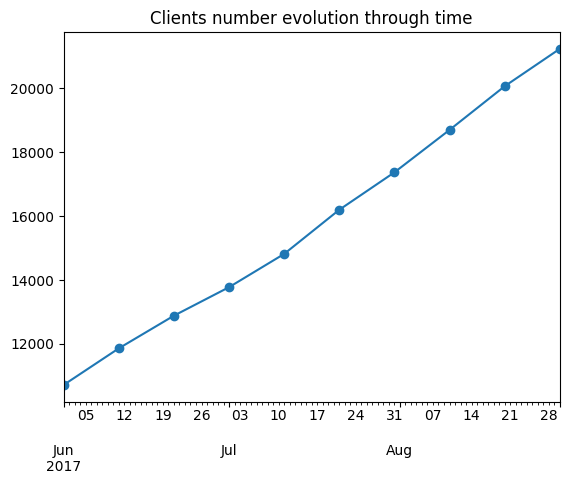

In [36]:
effectives_series = pd.Series(effectives, index=dates)
effectives_series.plot(kind='line',
                       title='Clients number evolution through time',
                       marker='o')
plt.show()

In [20]:
display(effectives_series.diff())
effectives_series.diff().mean()

2017-06-01       NaN
2017-06-11    1145.0
2017-06-21    1023.0
2017-07-01     893.0
2017-07-11    1042.0
2017-07-21    1383.0
2017-07-31    1172.0
2017-08-10    1329.0
2017-08-20    1368.0
2017-08-30    1172.0
Freq: 10D, dtype: float64

1169.6666666666667

In average, between june 2017 and the start of september 2017, each 10 days, about 1170 new clients joined the platform and made an order.

We can compute the average increase of clients between early september 2017 and the last time we get an information (mid october 2018):

In [29]:
((96095 - len(clients_t9)) * 10
/(orders_df.purchase_time.max()-dates.max()).days)

1812.6150121065375

So 'today', the platform is even more attractive. About 1800 new clients make an order each 10 days.

Thus, If we want to classify those new coming clients, we should maintain the clustering results every 10 days. Or at least, predict to which cluster new clients can be bounded to.

# 6.  [&#9650;](#toc0_) <a id='toc6_'></a>Pre-processing data for clustering


In [43]:
# Dictionary of those clients summaries pre-processed ; key 'tn'
clients_summary_pp = {
    key: pt.clustering_preprocessing(clients) 
    for key, clients in clients_summary.items()
}

,monetary_value_sum_pp,days_delivery_mean_pp,total_number_of_purchases_pp,value_ratio_p2_p1_pp,days_last_purchase_pp,review_score_mean_pp,ratio_value_home_pp,ratio_value_electronics_and_multimedia_pp,ratio_value_health_and_beauty_pp,new_ratio_value_other_pp,ratio_freight_value_pp,ratio_payment_value_credit_card_pp,ratio_payment_value_boleto_pp
customer_unique_id,,,,,,,,,,,,,
0000f46a3911fa3c0805444483337064,-0.295739,1.473828,0.693147,0.000000,0.626469,-0.973822,0.000000,0.000000,0.0,0.800278,0.199722,1.0,0.0
0005e1862207bf6ccc02e4228effd9a0,0.370424,-1.418077,0.693147,0.000000,0.744796,-0.156205,0.000000,0.000000,0.0,0.899281,0.100719,1.0,0.0
00115fc7123b5310cf6d3a3aa932699e,-0.445058,-0.035047,0.693147,0.000000,1.573080,-0.156205,0.000000,0.000000,0.0,0.788201,0.211799,1.0,0.0
0011805441c0d1b68b48002f1d005526,1.193963,0.923643,0.693147,0.693147,-0.260978,-0.973822,0.000000,0.905297,0.0,0.000000,0.094703,1.0,0.0
00191a9719ef48ebb5860b130347bf33,-0.751965,0.622201,0.693147,0.693147,-0.162373,-0.973822,0.813795,0.000000,0.0,0.000000,0.186205,1.0,0.0


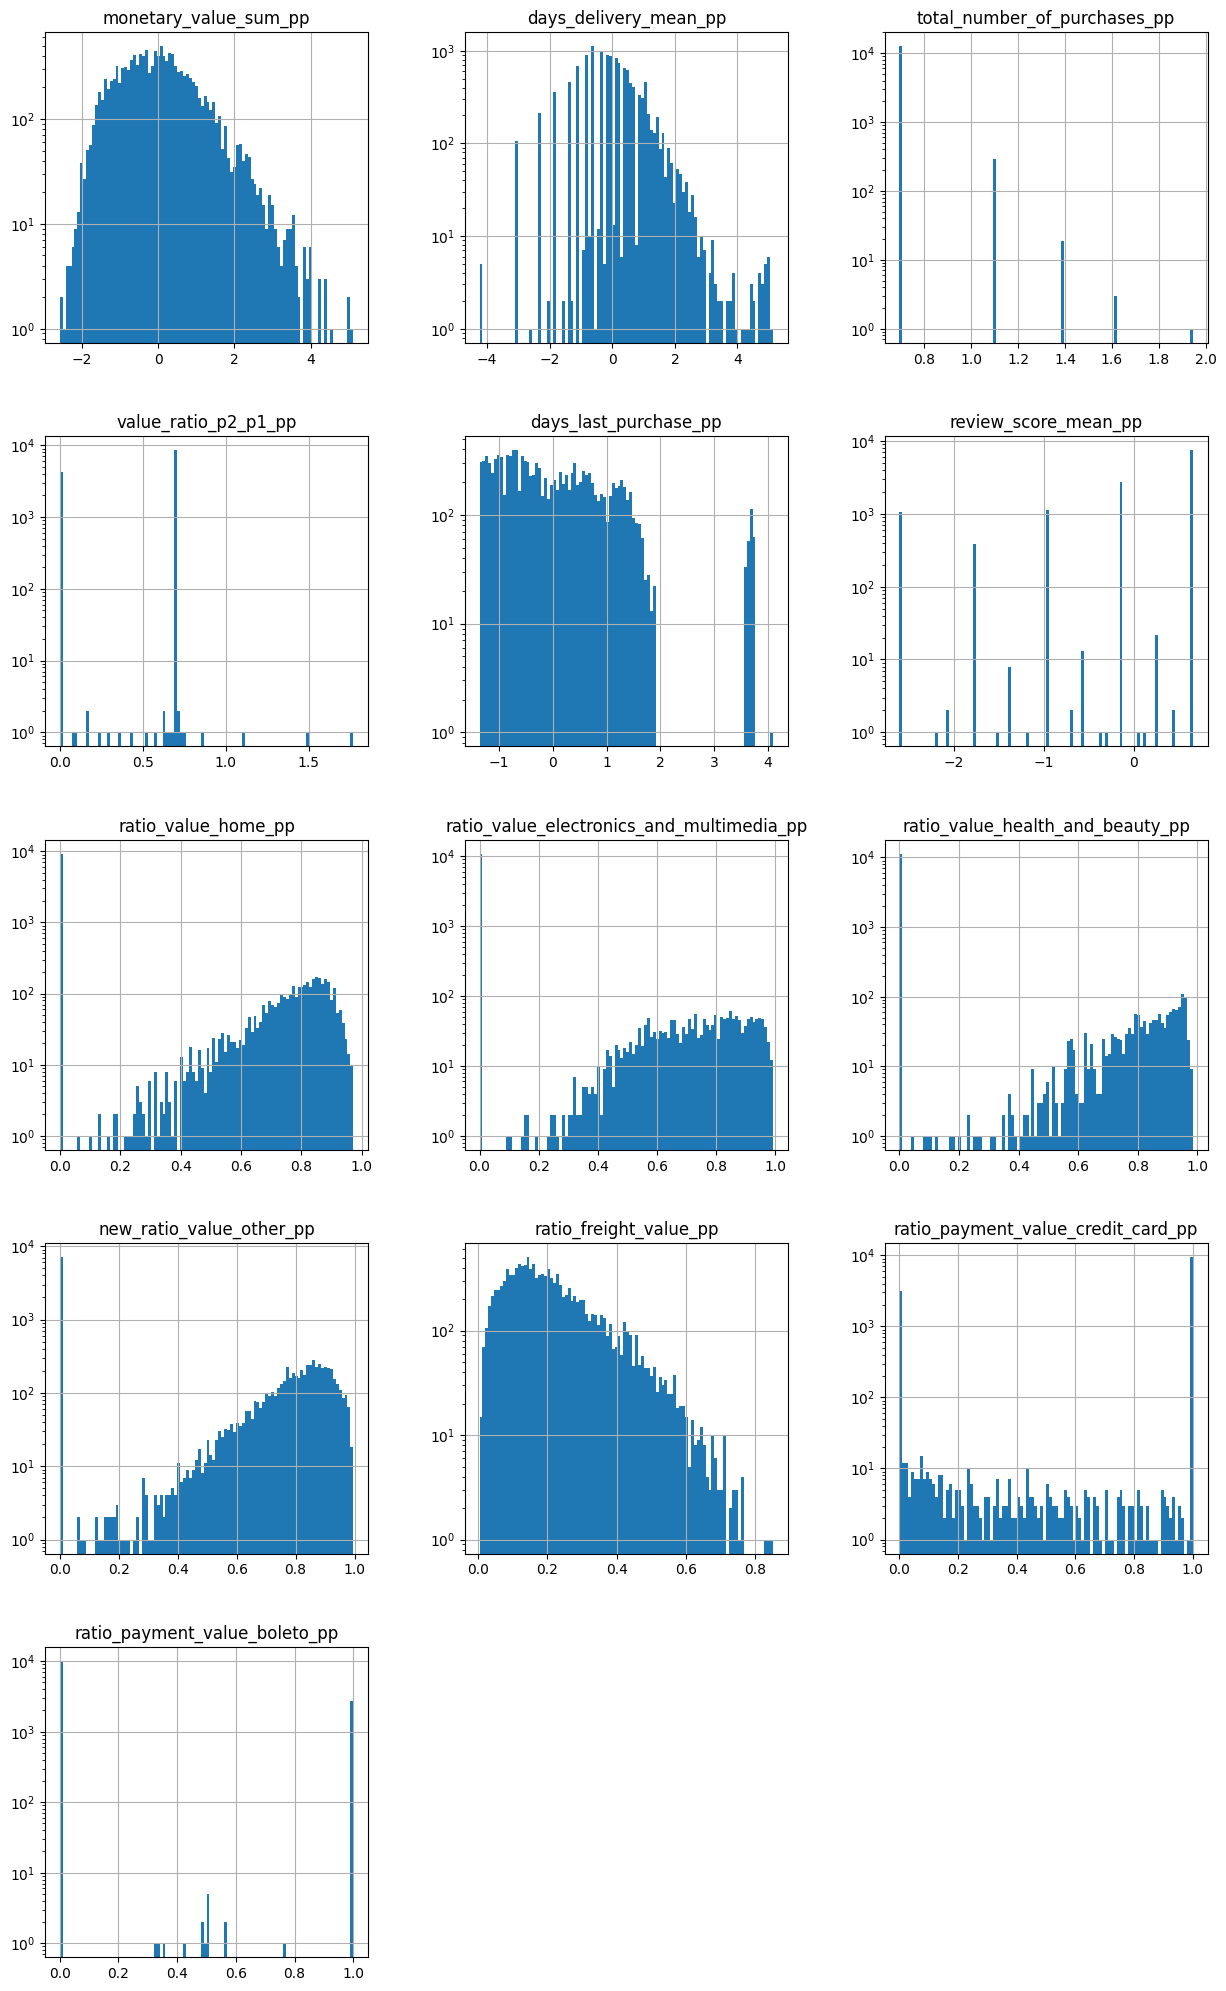

In [48]:
# Randomly checking one client summary pp
display(clients_summary_pp['t2'].head())
clients_summary_pp['t2'].hist(bins=100,
                              layout=(5,3),
                              figsize=(15, 25),
                              log=True)
plt.show()

# 7.  [&#9650;](#toc0_) <a id='toc7_'></a>Fit different Kmeans on each clients summaries (date-wise) to predict labels having all information.

In [65]:
# Dictionary of KMeans
n_periods = 10
kmeans_models = {
    't' + str(k): KMeans(n_clusters=5, n_init=10)
    for k in range(n_periods)
}

for k in range(n_periods):
    time = 't' + str(k)
    print(time)
    label_name = 'label_kmeans_fit_on_' + time
    model_input = clients_summary_pp[time]
    clients_summary[time].loc[:, label_name] = (kmeans_models[time]
                                                .fit_predict(model_input))

t0
t1
t2
t3
t4
t5
t6
t7
t8
t9


# 8.  [&#9650;](#toc0_) <a id='toc8_'></a>For each clients summaries at a certain date, add all predictions of labels with kmeans previously fit.

In [70]:
for k in range(1, n_periods):
    time = f't{k}'
    print(time)
    model_input = clients_summary_pp[time]
    for j in range(k):
        previous_time = f't{j}'
        model = kmeans_models[previous_time]
        label_name = 'label_kmeans_fit_on_' + previous_time
        clients_summary[time].loc[:, label_name] = model.predict(model_input)
    

t1
t2
t3
t4
t5
t6
t7
t8
t9


In [72]:
clients_summary['t9'].head()

,monetary_value_sum,days_delivery_mean,total_number_of_purchases,value_ratio_p2_p1,days_last_purchase,review_score_mean,ratio_value_home,ratio_value_electronics_and_multimedia,ratio_value_health_and_beauty,new_ratio_value_other,ratio_freight_value,ratio_payment_value_credit_card,ratio_payment_value_boleto,label_kmeans_fit_on_t9,label_kmeans_fit_on_t0,label_kmeans_fit_on_t1,label_kmeans_fit_on_t2,label_kmeans_fit_on_t3,label_kmeans_fit_on_t4,label_kmeans_fit_on_t5,label_kmeans_fit_on_t6,label_kmeans_fit_on_t7,label_kmeans_fit_on_t8
customer_unique_id,,,,,,,,,,,,,,,,,,,,,,,
0000f46a3911fa3c0805444483337064,86.22,25.0,1,0.0,172.0,3.0,0.000000,0.0,0.000000,0.800278,0.199722,1.0,0.0,3,4,2,0,4,4,2,0,4,0
0005e1862207bf6ccc02e4228effd9a0,150.12,4.0,1,0.0,178.0,4.0,0.000000,0.0,0.000000,0.899281,0.100719,1.0,0.0,2,0,1,1,3,2,4,3,1,3
0006fdc98a402fceb4eb0ee528f6a8d4,29.00,16.0,1,1.0,42.0,3.0,0.479310,0.0,0.000000,0.000000,0.520690,1.0,0.0,1,1,3,2,0,3,0,2,0,4
000a5ad9c4601d2bbdd9ed765d5213b3,91.28,11.0,1,1.0,18.0,4.0,0.000000,0.0,0.843449,0.000000,0.156551,1.0,0.0,1,1,3,2,0,3,0,2,0,4
000de6019bb59f34c099a907c151d855,257.44,4.0,1,1.0,12.0,2.0,0.892635,0.0,0.000000,0.000000,0.107365,1.0,0.0,3,4,2,0,4,4,2,0,4,0


In [121]:
clients_summary['t9'].isnull().sum()

monetary_value_sum                        0
days_delivery_mean                        0
total_number_of_purchases                 0
value_ratio_p2_p1                         0
days_last_purchase                        0
review_score_mean                         0
ratio_value_home                          0
ratio_value_electronics_and_multimedia    0
ratio_value_health_and_beauty             0
new_ratio_value_other                     0
ratio_freight_value                       0
ratio_payment_value_credit_card           0
ratio_payment_value_boleto                0
label_kmeans_fit_on_t9                    0
label_kmeans_fit_on_t0                    0
label_kmeans_fit_on_t1                    0
label_kmeans_fit_on_t2                    0
label_kmeans_fit_on_t3                    0
label_kmeans_fit_on_t4                    0
label_kmeans_fit_on_t5                    0
label_kmeans_fit_on_t6                    0
label_kmeans_fit_on_t7                    0
label_kmeans_fit_on_t8          

# 9.  [&#9650;](#toc0_) <a id='toc9_'></a>Adjusted rand index between the different kmeans models predictions.

 For some clients summary (after t4), I compute and plot the ARI between the labels of the 'today-fit kmeans model' and the labels predicted from previous kmeans models fit.

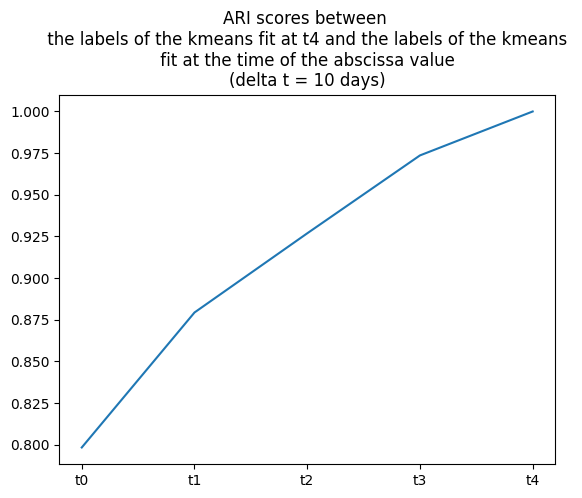

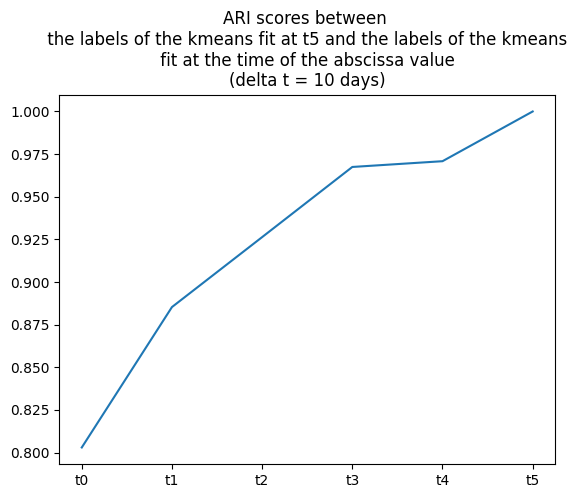

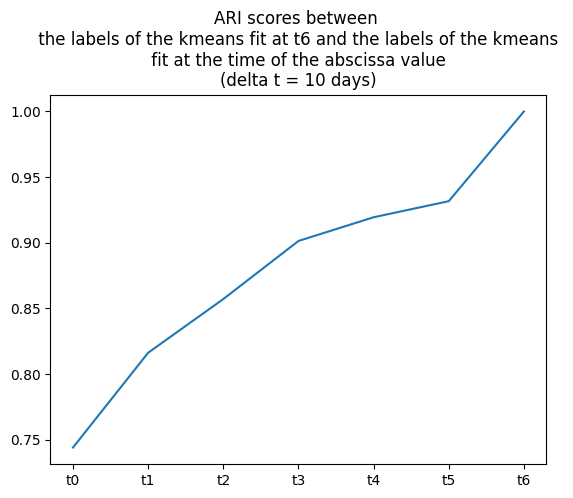

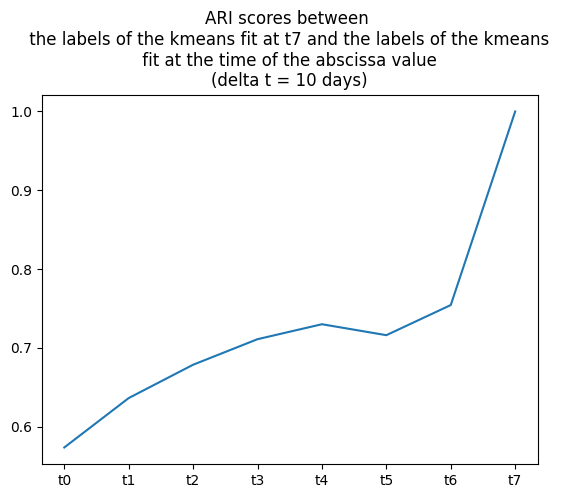

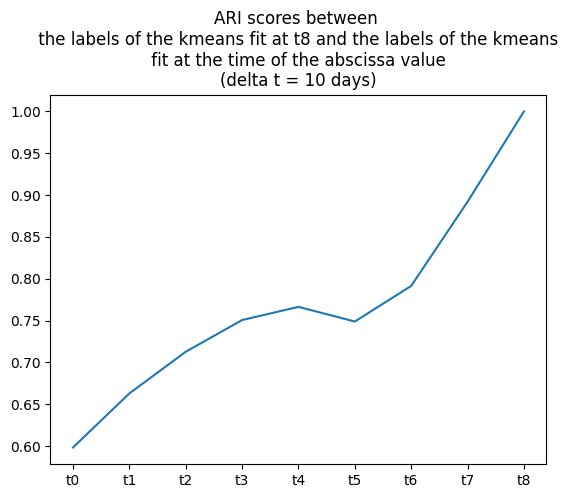

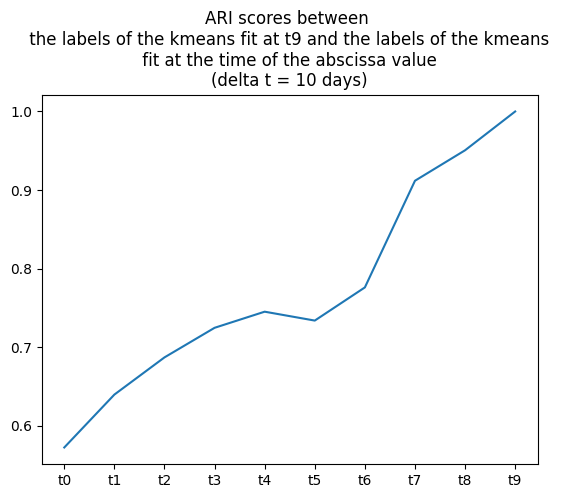

In [85]:
for n in range(4, 10):
    ARIs = []
    times = []
    last_time = f't{n}'
    df = clients_summary[last_time]
    ref_label = df['label_kmeans_fit_on_' + last_time]
    for k in range(n+1):
        time = f't{k}'
        times.append(time)
        label_name = 'label_kmeans_fit_on_' + time
        label_ = df[label_name]
        ARIs.append(adjusted_rand_score(ref_label, label_))
        
    plt.plot(range(1, n+2), ARIs,)
    plt.xticks(range(1, n+2), times)
    plt.title(f'ARI scores between \n the labels of the kmeans fit at t{n} and the '
            'labels of the kmeans \n fit at the time of the abscissa value \n'
            '(delta t = 10 days)')
    plt.show()

# 10.  [&#9650;](#toc0_) <a id='toc10_'></a>Centroids trajectories (stability)

In [86]:
# Fit a pca for visualization of the centroids
X = clients_summary_pp['t9']
pca = PCA()
pca.fit(X)

PCA()

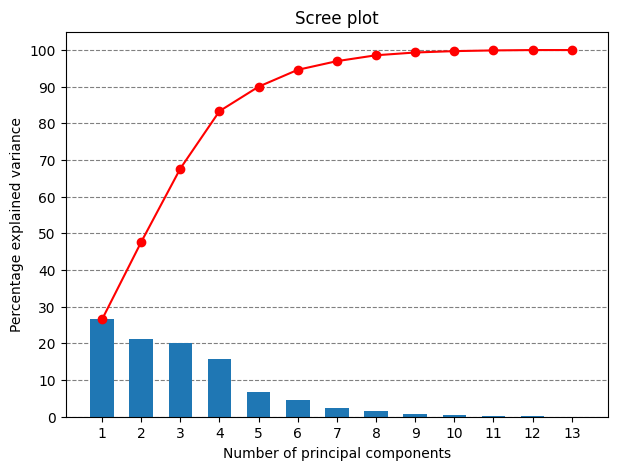

In [88]:
ds.display_scree_plot(pca)

Watching the centroids trajectories only in the 3 first factorial planes of the pca should reflect a decent amount of the (in)stability of the clustering model in function of the dataset increase.

In [91]:
# for each kmeans models fit at each time tn, extract the 5 centroids and 
# project in the pca space (eigenvectors computed on the last clients summary).
centroids_pca = dict()
for k in range(10):
    time = f't{k}'
    centroids = kmeans_models[time].cluster_centers_
    centroids_pca[time] = pca.transform(centroids)

/home/louberehc/miniconda3/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/home/louberehc/miniconda3/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/home/louberehc/miniconda3/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/home/louberehc/miniconda3/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/home/louberehc/miniconda3/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/home/louberehc/miniconda3/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does

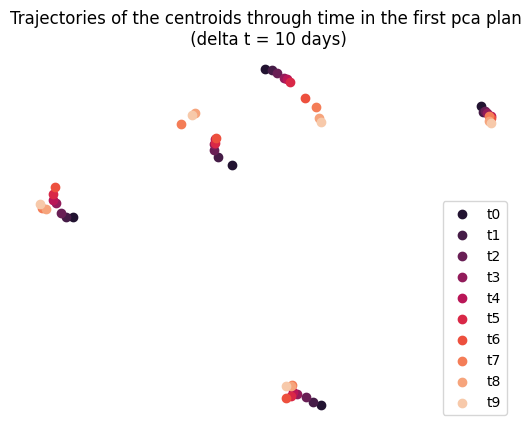

In [117]:
n_clusters = 5

# Plot centroids mouvement through kmeans fit
fig, ax = plt.subplots()
palette = sns.color_palette("rocket", n_colors=10)
# for each kmeans models
for k, (time, centroids) in enumerate(centroids_pca.items()):
    centroids_xs = []
    centroids_ys = []
    for n in range(n_clusters):
        centroids_xs.append(centroids[n][0]) 
        centroids_ys.append(centroids[n][1]) 
    ax.scatter(centroids_xs, centroids_ys, label=time, color=palette[k])
ax.legend()
ax.set_title('Trajectories of the centroids through time in the first pca plan'
             '\n (delta t = 10 days)')
ax.axis('off')
plt.show()
        

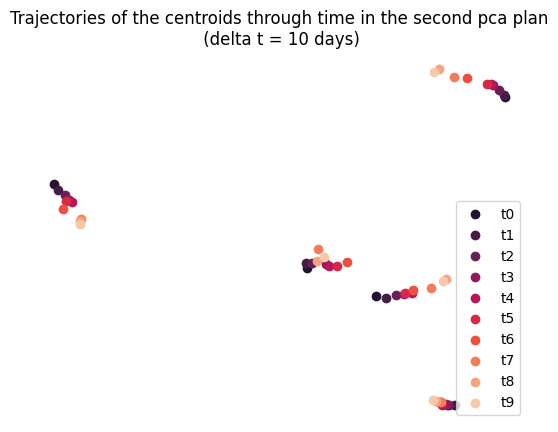

In [119]:
n_clusters = 5

# Plot centroids mouvement through kmeans fit
fig, ax = plt.subplots()
palette = sns.color_palette("rocket", n_colors=10)
# for each kmeans models
for k, (time, centroids) in enumerate(centroids_pca.items()):
    centroids_xs = []
    centroids_ys = []
    for n in range(n_clusters):
        centroids_xs.append(centroids[n][1]) 
        centroids_ys.append(centroids[n][2]) 
    ax.scatter(centroids_xs, centroids_ys, label=time, color=palette[k])
ax.legend()
ax.set_title('Trajectories of the centroids through time in the second pca plan'
             '\n (delta t = 10 days)')
ax.axis('off')
plt.show()
        

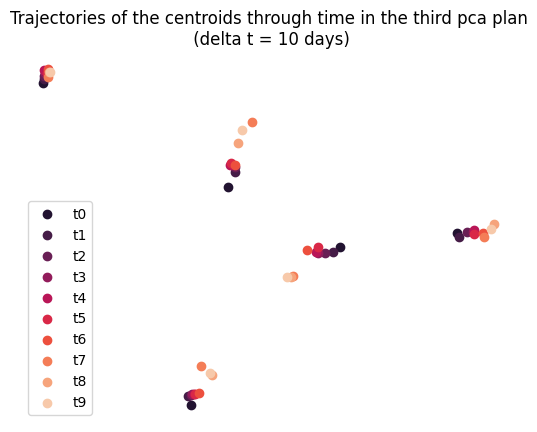

In [118]:
n_clusters = 5

# Plot centroids mouvement through kmeans fit
fig, ax = plt.subplots()
palette = sns.color_palette("rocket", n_colors=10)
# for each kmeans models
for k, (time, centroids) in enumerate(centroids_pca.items()):
    centroids_xs = []
    centroids_ys = []
    for n in range(n_clusters):
        centroids_xs.append(centroids[n][2]) 
        centroids_ys.append(centroids[n][3]) 
    ax.scatter(centroids_xs, centroids_ys, label=time, color=palette[k])
ax.legend()
ax.set_title('Trajectories of the centroids through time in the third pca plan'
             '\n (delta t = 10 days)')
ax.axis('off')
plt.show()